In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.env import Env
from rasterio.crs import CRS
from shapely.geometry import Polygon
from shapely.geometry import box
from tile_mate.stitcher import DATA_DIR
from dem_stitcher.geojson_io import to_geojson_gzip


In [2]:
with open('umd_ocean_mask_tiles.txt') as f:
    tiles = f.readlines()

In [3]:
tiles = list(map(lambda x: x.strip(), tiles))
tile_ids = list(map(lambda x: x.split('/')[-1].replace('.tif', ''), tiles))
fns = list(map(lambda x: x.split('/')[-1], tiles))
tile_ids[:3]

['00N_000E', '00N_010E', '00N_010W']

In [4]:
base_url = 'https://storage.googleapis.com/earthenginepartners-hansen/OceanMask'
tile_urls = [f'{base_url}/{fn}' for fn in fns]
tile_urls[:3]

['https://storage.googleapis.com/earthenginepartners-hansen/OceanMask/00N_000E.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/OceanMask/00N_010E.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/OceanMask/00N_010W.tif']

In [5]:
t = tiles[0]

with Env(GS_NO_SIGN_REQUEST='YES'):
    with rasterio.open(t) as ds:
        p = ds.profile
print(p, t)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00025, 0.0, 0.0,
       0.0, -0.00025, 0.0), 'blockxsize': 40000, 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'} gs://earthenginepartners-hansen/OceanMask/00N_000E.tif


In [6]:
def get_bounds_from_tile_id(tile_id: str) -> tuple[float]:
    lat_str = tile_id[:3]
    lon_str = tile_id[4:]
    lat = float(tile_id[:2])
    lon = float(tile_id[4:7])
    if 'S' in lat_str:
        lat = -lat
    if 'W' in lon_str:
        lon = -lon
    return lon, lat - 10, lon + 10, lat

def get_geometry(tile_id: str) -> Polygon:
    bounds = get_bounds_from_tile_id(tile_id)        
    return box(*bounds)

In [7]:
tile_ids[0][:3]

'00N'

In [8]:
geometry_l = [get_geometry(t) for t in tile_ids]
geometry_l[:3]

[<POLYGON ((10 -10, 10 0, 0 0, 0 -10, 10 -10))>,
 <POLYGON ((20 -10, 20 0, 10 0, 10 -10, 20 -10))>,
 <POLYGON ((0 -10, 0 0, -10 0, -10 -10, 0 -10))>]

In [9]:
df = gpd.GeoDataFrame({'tile_id': tile_ids, 'url': tile_urls}, geometry=geometry_l, crs=CRS.from_epsg(4326))

<Axes: >

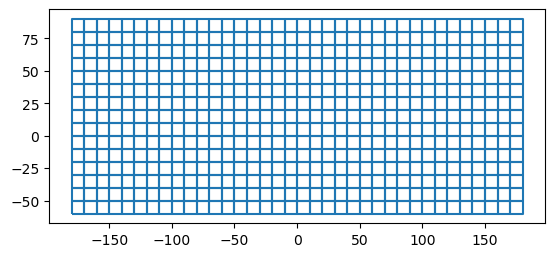

In [10]:
df.boundary.plot()

In [11]:
to_geojson_gzip(df, str(DATA_DIR / 'umd_ocean_mask.geojson.zip'))

'/Users/cmarshak/bekaert-team/tile-mate/src/tile_mate/data/umd_ocean_mask.geojson.zip'